<a href="https://colab.research.google.com/github/seoyun0311/simulation/blob/main/5_SimPy_Car_Wash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
%pip install simpy
%pip install fitter
import simpy
import random
from fitter import Fitter
import matplotlib.pyplot as plt

In [28]:
car_interarrival_data = [
    1.35166493e+00, 1.36167980e-01, 1.84202857e-01, 3.17178141e-01, 2.51452263e+00, 2.65475771e-02,
    1.67443339e-01, 2.09940735e+00, 3.41459398e+00, 1.49252804e-01, 8.74826243e-01, 5.09988862e-02,
    3.67731571e-01, 3.77030083e-01, 8.53583257e-02, 5.31342615e+00, 1.91600101e+00, 1.94930075e-01,
    2.04986668e+00, 2.85673099e+00, 9.75932581e-01, 1.94861521e-01, 6.87801682e-01, 6.63802815e-01,
    2.98096432e+00, 5.37112331e-01, 1.88873714e-01, 1.87810825e+00, 5.43372567e-01, 1.59540088e+00,
    1.35160483e+00, 1.26024903e+00, 3.26581711e-01, 1.90230924e+00, 4.93460497e-01, 1.74663821e-01,
    4.53647701e-01, 4.51542578e-04, 1.38575055e-01, 2.49413797e+00, 4.54583938e-01, 1.85416115e-01,
    3.09104530e-01, 1.59440932e-01, 5.30669164e-01, 1.31789452e+00, 1.63107760e+00, 1.95897103e-01,
    5.18152889e-01, 5.80059344e-01, 2.06985808e+00, 1.55236941e-01, 4.52139818e-01, 1.34950675e+00,
    8.34712429e-01, 1.48393461e-01, 7.90668730e-01, 1.09956407e+00, 2.13323567e-01, 9.73275625e-02,
    3.02919707e+00, 9.79011089e-01, 1.78671931e+00, 6.78908197e-01, 8.11495323e-01, 7.32587321e-01,
    2.12304209e+00, 3.62475404e-02, 4.90550291e-01, 3.93394704e-01, 2.25658935e+00, 8.56790200e-01,
    5.10164918e-01, 1.01885052e-01, 1.92661884e+00, 1.25556899e+00, 1.16785463e-01, 4.46713059e-01,
    1.03879301e+00, 6.22589722e-01, 6.70299754e-02, 1.40772612e+00, 1.43272098e+00, 4.77824425e-02,
    8.21307291e-01, 2.55688529e-02, 1.93705664e-01, 3.02083695e-01, 9.35247162e-01, 1.98320867e+00,
    2.01670473e-01, 7.48256391e-02, 2.13309391e+00, 5.43444933e-01, 6.30951003e-02, 1.63619863e-01,
    1.42022203e+00, 5.78601898e-01, 1.70263363e+00, 1.39347881e-02
]

In [29]:
# 최적의 도착 간격 분포 찾기
f = Fitter(car_interarrival_data, distributions=['uniform', 'norm', 'expon', 'gamma'])
f.fit()

best_distribution = f.get_best()
print("가장 적합한 분포:")
print(best_distribution)

가장 적합한 분포:
{'expon': {'loc': 0.000451542578, 'scale': 0.9064284160297801}}


In [30]:
# 시뮬레이션 파라미터 설정
RANDOM_SEED = 7                # 난수 시드
NUM_MACHINES = 2               # 세차 기계의 수
WASHTIME = 1                   # 세차에 걸리는 시간 (단위: 시간)
SIM_TIME = 20                  # 총 시뮬레이션 시간 (단위: 시간)

random.seed(RANDOM_SEED)       # 난수 시드 설정
Q = []                         # 대기열 상태 저장
B = []                         # 자원 사용 상태 저장

In [31]:
# 세차 작업 정의
def wash(env, car):
    yield env.timeout(WASHTIME)  # 세차 시간 대기

# 고객 프로세스 정의
def car(env, name, carwash, num_machines):
    global Q, B
    print(f'{name}이(가) {env.now:.2f}에 세차장에 도착했습니다.')  # 도착 시점 출력
    arrival_time = env.now

# env.now = 시점

    # 자원 요청
    request = carwash.request()
    yield request # 자원 요청 완료까지 대기

    # 대기 시간 기록
    Q.append((round(env.now, 2), len(carwash.queue))) # 대기열 길이 기록
    B.append((round(env.now, 2), carwash.count)) # 자원 사용 상태 기록

    wait_time = env.now - arrival_time  # 대기 시간 계산
    if wait_time > 0:
        print(f'{name}이(가) {env.now:.2f}에 대기 후 세차장에 들어갔습니다.')  # 대기 후 입장
    else:
        print(f'{name}이(가) {env.now:.2f}에 바로 세차장에 들어갔습니다.')  # 바로 입장

    # 세차 작업 시작
    yield env.process(wash(env, name)) # 세차 프로세스 실행

    print(f'{name}이(가) {env.now:.2f}에 세차장을 떠났습니다.')  # 세차 완료 시점 출력

    # 서비스 완료 후 자원 반납
    carwash.release(request)

    # 대기 시간 기록
    Q.append((round(env.now, 2), len(carwash.queue)))
    B.append((round(env.now, 2), carwash.count))

# 세차장 초기화 및 고객 생성 설정
def setup(env, num_machines, scale):
    carwash = simpy.Resource(env, num_machines)  # 세차 기계 자원 생성
    car_count = 1  # 자동차 번호 초기화

    # 초기 자동차 4대 생성
    for _ in range(4):
        env.process(car(env, f'Car {car_count}', carwash, num_machines))
        car_count += 1  # 자동차 번호 증가

    while True:
        # 지수 분포를 사용하여 도착 간격을 생성
        interarrival_time = random.expovariate(1/scale)  # scale에 따라 평균 간격 조정
        yield env.timeout(interarrival_time) # interarrival_time만큼 대기
        env.process(car(env, f'Car {car_count}', carwash, num_machines))  # 고객 프로세스 생성
        car_count += 1  # 자동차 번호 증가

In [32]:
# 지수 분포에서의 scale 값 설정
scale = 0.9064284160297801

In [33]:
print('세차장 시작')
env = simpy.Environment()  # SimPy 환경 생성
env.process(setup(env, NUM_MACHINES, scale))    # 고객 생성 프로세스 추가
env.run(until=SIM_TIME)  # 시뮬레이션 실행

세차장 시작
Car 1이(가) 0.00에 세차장에 도착했습니다.
Car 2이(가) 0.00에 세차장에 도착했습니다.
Car 3이(가) 0.00에 세차장에 도착했습니다.
Car 4이(가) 0.00에 세차장에 도착했습니다.
Car 1이(가) 0.00에 바로 세차장에 들어갔습니다.
Car 2이(가) 0.00에 바로 세차장에 들어갔습니다.
Car 5이(가) 0.35에 세차장에 도착했습니다.
Car 6이(가) 0.50에 세차장에 도착했습니다.
Car 1이(가) 1.00에 세차장을 떠났습니다.
Car 2이(가) 1.00에 세차장을 떠났습니다.
Car 3이(가) 1.00에 대기 후 세차장에 들어갔습니다.
Car 4이(가) 1.00에 대기 후 세차장에 들어갔습니다.
Car 7이(가) 1.46에 세차장에 도착했습니다.
Car 8이(가) 1.53에 세차장에 도착했습니다.
Car 3이(가) 2.00에 세차장을 떠났습니다.
Car 4이(가) 2.00에 세차장을 떠났습니다.
Car 5이(가) 2.00에 대기 후 세차장에 들어갔습니다.
Car 6이(가) 2.00에 대기 후 세차장에 들어갔습니다.
Car 9이(가) 2.22에 세차장에 도착했습니다.
Car 10이(가) 2.63에 세차장에 도착했습니다.
Car 11이(가) 2.69에 세차장에 도착했습니다.
Car 5이(가) 3.00에 세차장을 떠났습니다.
Car 6이(가) 3.00에 세차장을 떠났습니다.
Car 7이(가) 3.00에 대기 후 세차장에 들어갔습니다.
Car 8이(가) 3.00에 대기 후 세차장에 들어갔습니다.
Car 12이(가) 3.33에 세차장에 도착했습니다.
Car 13이(가) 3.36에 세차장에 도착했습니다.
Car 14이(가) 3.88에 세차장에 도착했습니다.
Car 15이(가) 3.95에 세차장에 도착했습니다.
Car 7이(가) 4.00에 세차장을 떠났습니다.
Car 8이(가) 4.00에 세차장을 떠났습니다.
Car 9이(가) 4.00에 대기 후 세차장에 들어갔습니다.
Car 10이(가) 4.00에 대기 후 세차장에

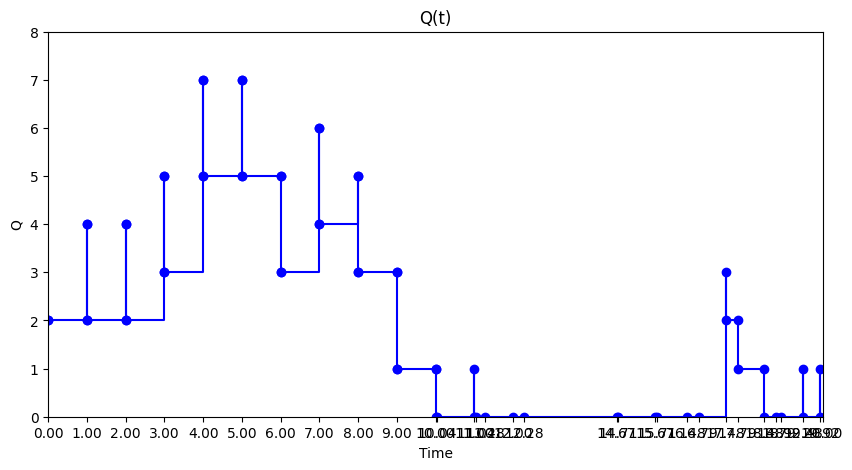

In [34]:
# Q(t) 그래프
times, queue_lengths = zip(*Q)
xticks_times = sorted(set(times + (SIM_TIME,)))
plt.figure(figsize=(10, 5))
plt.step(times, queue_lengths, where='post', marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Q')
plt.title('Q(t)')
plt.xticks(xticks_times, [f'{t:.2f}' for t in xticks_times])
plt.yticks(range(0, max(queue_lengths) + 2, 1))
plt.ylim(0, max(queue_lengths) + 1)
plt.xlim(0, SIM_TIME)
plt.grid(False)
plt.show()

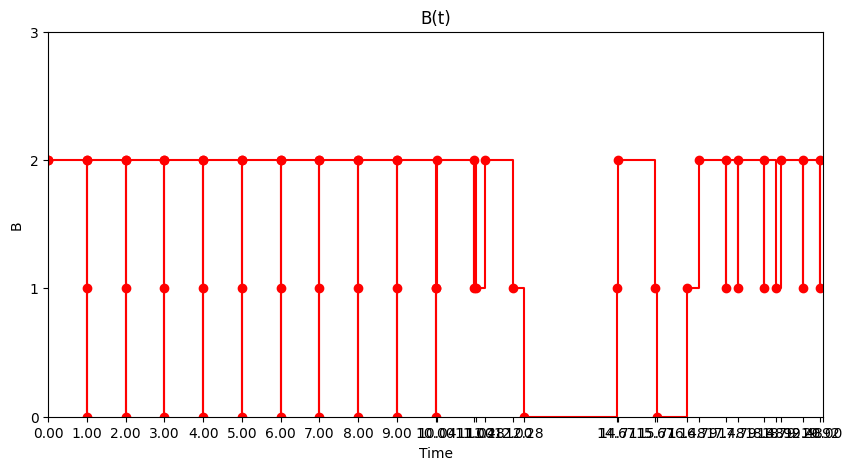

In [35]:
# B(t) 그래프
times_B, resource_states = zip(*B)
xticks_times_B = sorted(set(times_B + (SIM_TIME,)))
plt.figure(figsize=(10, 5))
plt.step(times_B, resource_states, where='post', marker='o', linestyle='-', color='r')
plt.xlabel('Time')
plt.ylabel('B')
plt.title('B(t)')
plt.xticks(xticks_times_B, [f'{t:.2f}' for t in xticks_times_B])
plt.yticks(range(0, NUM_MACHINES + 2, 1))
plt.ylim(0, NUM_MACHINES + 1)
plt.xlim(0, SIM_TIME)
plt.grid(False)
plt.show()